<a href="https://colab.research.google.com/github/kocurvik/edu/blob/master/3DV/labs/3DV_cv03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3rd Lab - Pinhole Camera Model

## OpenCV

OpenCV is an image manipulation library. We will use throughout this course. It is pre-installed in Coogle Colab, but you can easily install it using conda or pip on your local machine.

In [ ]:
import cv2

Loading an image in OpenCV is simple. We will now download an image using wget and then load it using Opnecv. The image is a NumPy array with dimensions: height x width x 3. The last channel represents the three RGB components. **Though it is important to note that in OpenCV the default order of channels is BGR**.

In [ ]:
!wget https://www.google.com/images/branding/googlelogo/1x/googlelogo_color_272x92dp.png
img = cv2.imread('googlelogo_color_272x92dp.png')
print(type(img))
print(img.shape)
print(img.dtype)

--2023-02-28 22:17:37--  https://www.google.com/images/branding/googlelogo/1x/googlelogo_color_272x92dp.png
Resolving www.google.com (www.google.com)... 173.194.217.106, 173.194.217.99, 173.194.217.103, ...
Connecting to www.google.com (www.google.com)|173.194.217.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5969 (5.8K) [image/png]
Saving to: ‘googlelogo_color_272x92dp.png’

googlelogo_color_27 100%[===================>]   5.83K  --.-KB/s    in 0s      

2023-02-28 22:17:37 (62.9 MB/s) - ‘googlelogo_color_272x92dp.png’ saved [5969/5969]

<class 'numpy.ndarray'>
(92, 272, 3)
uint8


Displaying an image is slightly complicated. We will use the matplotlib library for this purpose. Before we can display the image we have to flip the order of the channels from BGR to RGB.

The commented part of the code shows how this could be done outside of the notebook environments. cv2.waitKey halts the program from the given amount of time in miliseconds or until a key is pressed. If the argument is zero the program waits for a keypress indefinitely.


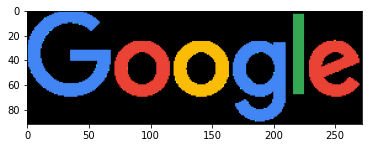

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img[:,:,::-1])
plt.show()

# cv2.imshow('Obrazok', img)
# if cv2.waitKey(0) & 0xFF == ord('q'):
#     return

We can also display the individual channels.

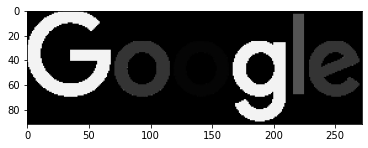

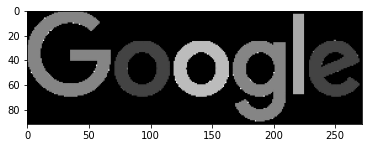

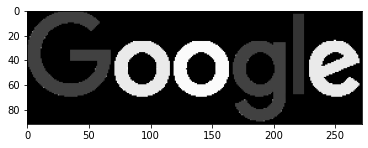

In [ ]:
plt.imshow(img[:,:,0],cmap='gray')
plt.show()
plt.imshow(img[:,:,1],cmap='gray')
plt.show()
plt.imshow(img[:,:,2],cmap='gray')
plt.show()

Images are in uint8 (integers 0 - 255) by default. Sometimes we will work with floats. In that case the values have to be from 0 to 1 to be properly displayed.

float64


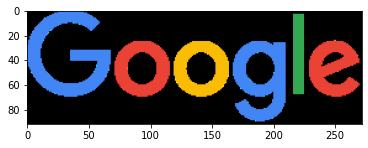

In [ ]:
img_f = img / 255
print(img_f.dtype)
plt.imshow(img_f[:,:,::-1])
plt.show()

Sometimes we want to convert the image to grayscale using `cv2.cvtColor`.

In [ ]:
!wget 'https://upload.wikimedia.org/wikipedia/commons/0/0a/Malachite_kingfisher_(Corythornis_cristatus_stuartkeithi).jpg'
!mv 'Malachite_kingfisher_(Corythornis_cristatus_stuartkeithi).jpg' bird.jpg
!ls -l

--2023-02-28 22:17:39--  https://upload.wikimedia.org/wikipedia/commons/0/0a/Malachite_kingfisher_(Corythornis_cristatus_stuartkeithi).jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3272846 (3.1M) [image/jpeg]
Saving to: ‘Malachite_kingfisher_(Corythornis_cristatus_stuartkeithi).jpg’

Malachite_kingfishe 100%[===================>]   3.12M  10.6MB/s    in 0.3s    

2023-02-28 22:17:40 (10.6 MB/s) - ‘Malachite_kingfisher_(Corythornis_cristatus_stuartkeithi).jpg’ saved [3272846/3272846]

total 3212
-rw-r--r-- 1 root root 3272846 Feb  7  2018 bird.jpg
-rw-r--r-- 1 root root    5969 Oct 22  2019 googlelogo_color_272x92dp.png
drwxr-xr-x 1 root root    4096 Feb 27 14:36 sample_data


We can then display the image, but the imshow method needs an additional argument to force the display output to have the correct color scheme.

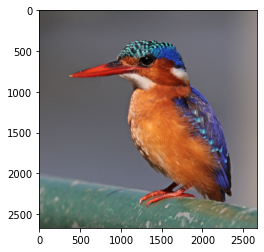

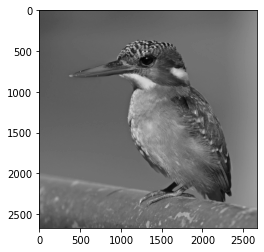

In [ ]:
img_b = cv2.imread('bird.jpg')
plt.imshow(img_b[:,:,::-1])
plt.show()
img_g = cv2.cvtColor(img_b, cv2.COLOR_BGR2GRAY)
plt.imshow(img_g, cmap='gray')
plt.show()

## Simple Pinhole Camera Projection

We will implement a simple projection from real world coordinates to image coordinates. First we will download files containing 3D points.

In [ ]:
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt


!wget https://github.com/kocurvik/edu/raw/master/3DV/labs/resources/fmfi_logo.npy
!wget https://github.com/kocurvik/edu/raw/master/3DV/labs/resources/fmfi_logo_moved.npy

--2023-02-28 22:17:50--  https://github.com/kocurvik/edu/raw/master/3DV/labs/resources/fmfi_logo.npy
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kocurvik/edu/master/3DV/labs/resources/fmfi_logo.npy [following]
--2023-02-28 22:17:50--  https://raw.githubusercontent.com/kocurvik/edu/master/3DV/labs/resources/fmfi_logo.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184400 (180K) [application/octet-stream]
Saving to: ‘fmfi_logo.npy’

fmfi_logo.npy       100%[===================>] 180.08K  --.-KB/s    in 0.02s   

2023-02-28 22:17:50 (7.48 MB/s) - ‘fmfi_logo.npy’ saved [184400/184400]

--202

We can visualize the data.

In [ ]:
logo_points = np.load('fmfi_logo.npy')
logo_moved_points = np.load('fmfi_logo_moved.npy')

fig = px.scatter_3d(x = logo_points[:, 0], y = logo_points[:, 1], z=logo_points[:, 2])
fig.update_traces(marker={'size': 1})
fig.show()


fig = px.scatter_3d(x = logo_moved_points[:, 0], y = logo_moved_points[:, 1], z=logo_moved_points[:, 2])
fig.update_traces(marker={'size': 1})
fig.show()

### Exercise - Simple Projection

Project the points contained in the `logo_points` using a simple pinhole camera model. Use camera with $R = I$ and $\vec{t} = \vec{0}$. Check how changing the focal lenght $f = f_x = f_y$ changes the output. Check the same for different values of skew $s$ and principal point $(x_0, y_0)$. To plot the resulting points use the the method `scatter` from `matplotlib`.

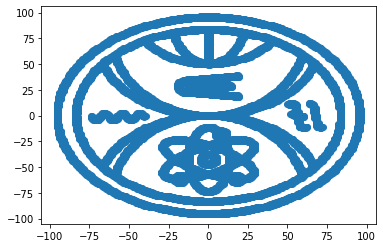

In [ ]:
...

### Exercise - Pinhole Camera Model with rotation and translation

Now try to visualize the points loaded as `logo_moved_points`. In order to properly visualize them you will need to use a rotation matrix for which the euler angles are 30, 40 and 0 degrees and the translation vector is $(0, -5, -10)$.

You can use `scipy.spatial.transform.Rotation` from the SciPy library to convert between the different representations.

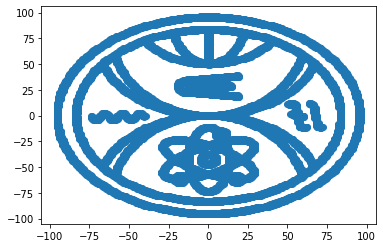

In [ ]:
...

## Camera Calibration

In the following code you will download a zip file with multiple images of a calibration pattern. This pattern can be used to calibrate the camera (relatively cheap phone camera). The calibration is based on detecting a calibration pattern in multiple images and then solving for the camera parameters given correspondences between the known positions of points on pattern (in this case corners on a checkerboard).

In [ ]:
!wget https://github.com/kocurvik/edu/raw/master/PSO/images/calib.zip
!unzip calib.zip

--2023-02-28 22:17:57--  https://github.com/kocurvik/edu/raw/master/PSO/supplementary/calib.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kocurvik/edu/master/PSO/supplementary/calib.zip [following]
--2023-02-28 22:17:57--  https://raw.githubusercontent.com/kocurvik/edu/master/PSO/supplementary/calib.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34918999 (33M) [application/zip]
Saving to: ‘calib.zip’

calib.zip           100%[===================>]  33.30M  67.8MB/s    in 0.5s    

2023-02-28 22:17:58 (67.8 MB/s) - ‘calib.zip’ saved [34918999/34918999]

Archive:  calib.zip
  inflating:

### Exercise - Undistort

Calibrate the camera using [this tutorial](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html) and undistort one of the images.

IMG_20181018_124625122.jpg
IMG_20181018_124627291.jpg
IMG_20181018_124629779.jpg
IMG_20181018_124637823.jpg
IMG_20181018_124642449.jpg
IMG_20181018_124645144.jpg
IMG_20181018_124649042.jpg
IMG_20181018_124659162.jpg
IMG_20181018_124706096.jpg


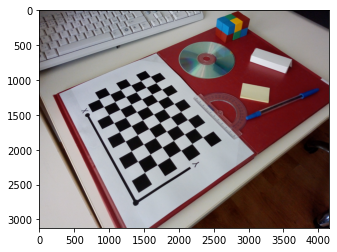

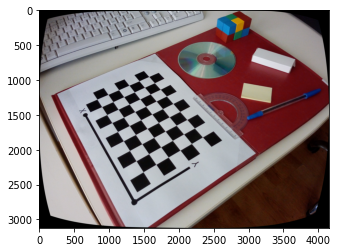

In [ ]:
...

### Exercise - Rotate

In this exercise you should use the knowledge from the lecture and create a synthetic view that would be obtained if the camera axis was perpendicular to the checkerboard. You may find it useful to use the `cv2.warpPerspective` method to obtain the final image.

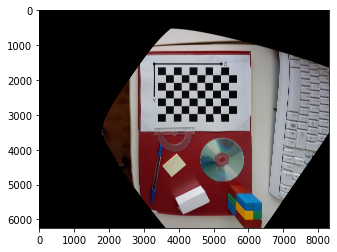

In [ ]:
...

### Using OpenCV remap

In this exercise you will use an image which was artificially distorted. Your objective is to revert the distortion. The original image `chip.jpg` was distorted using this formula:

$$ \hat{y} - y_0 = \frac{y - y_0}{\left(1 + \text{sin}(\omega r)\right)} $$
$$ \hat{x} - x_0 = \frac{x - x_0}{\left(1 + \text{sin}(\omega r) \right)},$$

where $r = \sqrt{ (x - x_0)^2 + (y - y_0)^2}$, $(x_0, y_0)$ is in the center of the image, $\omega = 0.05$. The resulting image can be found in the file `chip_distorted.jpg`. Undo this distortion and compare the resulting image with the distortion.

The code below downloads these images.

In [ ]:
!wget "https://raw.githubusercontent.com/kocurvik/edu/master/3DV/labs/resources/chip.jpg"
!wget "https://raw.githubusercontent.com/kocurvik/edu/master/3DV/labs/resources/chip_distorted.jpg"

--2023-02-28 22:18:19--  https://raw.githubusercontent.com/kocurvik/edu/master/3DV/labs/resources/chip.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34187 (33K) [image/jpeg]
Saving to: ‘chip.jpg’

chip.jpg            100%[===================>]  33.39K  --.-KB/s    in 0.002s  

2023-02-28 22:18:19 (16.7 MB/s) - ‘chip.jpg’ saved [34187/34187]

--2023-02-28 22:18:19--  https://raw.githubusercontent.com/kocurvik/edu/master/3DV/labs/resources/chip_distorted.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55816 (55K) [image/jp

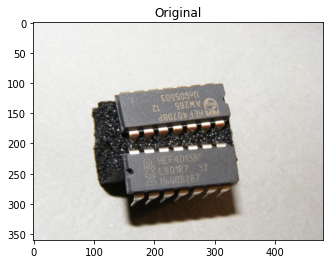

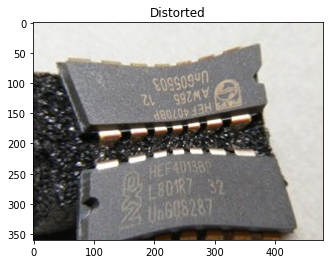

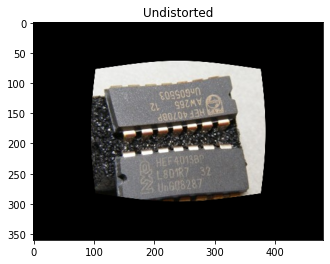

In [ ]:
...